Universal DSM prediction using a three-mode BSW (6) with the parameters {$\alpha_1$, $\alpha_2$, $\alpha_3$} and {$\tau_1$, $\tau_2$, $\tau_3$, $\tau_4$} as functions of $N_c$ only.

In [1]:
from mpmath import *
import numpy as np
import matplotlib.pyplot as plt
mp.dps = 25; mp.pretty = True
from scipy.interpolate import interp1d
from scipy.optimize import broyden1

In [2]:
filename = 'GsEd.dat'
Mw = 204000
T = 30
rho = -(T + 273.15)*0.00056 + 1.0547
MK = 103.9

In [3]:
def supp_prod(tauv, alpha, i):
    result = 1
    for j in range (1, i+1):
        result *= tauv[j]**(alpha[j - 1] - alpha[j])
    return result

def GSBSW(omega, alpha, tauv, n, G0):
    sum1 = 0
    for i in range(0, n):
        sum1 += gamma(1 + alpha[i])*(tauv[i + 1]**(1 + alpha[i])*hyp2f1(1, 1 + alpha[i], 2 + alpha[i], -j*tauv[i + 1]*omega)/gamma(2 + alpha[i]) - tauv[i]**(1 + alpha[i])*hyp2f1(1, 1 + alpha[i], 2 + alpha[i], -j*tauv[i]*omega)/gamma(2 + alpha[i]))*supp_prod(tauv, alpha, i)
    sum2 = 0
    for i in range(0, n):
        sum2 += (tauv[i + 1]**alpha[i] - tauv[i]**alpha[i])/alpha[i]*supp_prod(tauv, alpha, i)
    result =j*omega*sum1/sum2*G0
    return (re(result),im(result))

def GsCFSM(omega, Nc):
    n=3
    alpha1 = (-0.0005, -0.0205)
    alpha2 = (0.00029, 0.109957)
    alpha3 = (17.69589, 1.04026, -0.00095677)
    tau1 = (0.6288876, 0.119458)
    tau2 = (1.52508156, 0.02996758796795)
    tau3 = (3.110954, 0.022615)
    tau4 = (3.4840295, 0.0142809)
    alpha = (alpha1[0]*Nc + alpha1[1], alpha2[0]*Nc + alpha2[1], alpha3[0]/Nc + alpha3[1] + alpha3[2]*Nc)
    tauv = (tau1[1]*Nc**tau1[0], tau2[1]*Nc**tau2[0], tau3[1]*Nc**tau3[0], tau4[1]*Nc**tau4[0])
    return GSBSW(omega, alpha, tauv, n, 1)

def GsR(omega):
    n=3
    alpha = (0.64635, -0.4959, -1.2716)
    tauv = (6.313268381616272e-9, 2.181509372282138e-7, 0.797317365925168,  18.201382525250114)
    GR = 1942.29;
    return GSBSW(omega, alpha, tauv, n, GR)

#Vectorize functions
GsCFSM_vec=np.vectorize(GsCFSM, excluded=['Nc'])
GsR_vec=np.vectorize(GsR)

#Open experimental data
with open('GsEd.dat') as f:
    lines = f.readlines()
    t = np.array([float(line.split()[0]) for line in lines])
    Gp = np.array([float(line.split()[1]) for line in lines])
    Gdp = np.array([float(line.split()[2]) for line in lines])

In [4]:
fp = interp1d(t, Gp)
fdp = interp1d(t, Gdp)
ninterp=10000
xinterprange=10**np.linspace(np.log10(t[0]), np.log10(t[-1]), ninterp)[0:-2]
tand = fp(xinterprange)/fdp(xinterprange)
sol = np.abs(tand-1).argmin()
lfx = xinterprange[sol]
Gc = fp(xinterprange)[sol]

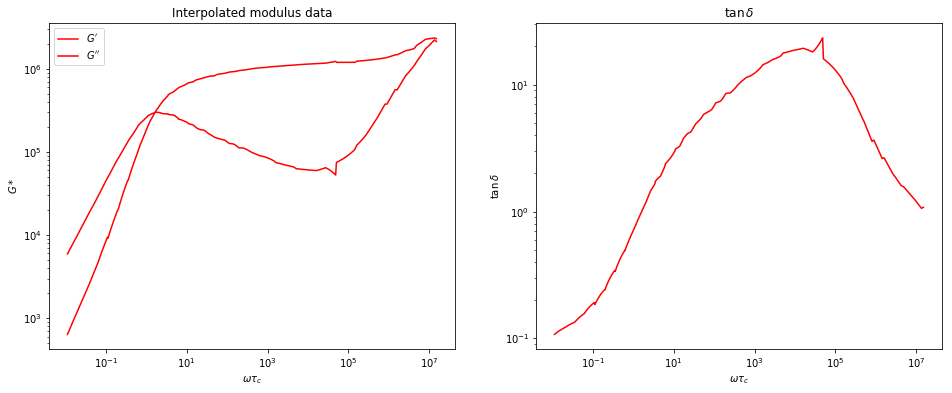

In [5]:
fig2 = plt.figure(figsize=(16, 6))

ax1 = fig2.add_subplot(121)

ax1.set_title("Interpolated modulus data")
ax1.set_xlabel(r'$\omega\tau_c$')
ax1.set_ylabel(r'$G*$')

ax1.plot(xinterprange,fp(xinterprange), c='r', label=r'$G^\prime$')
ax1.plot(xinterprange,fdp(xinterprange), c='r', label=r'$G^{\prime\prime}$')

leg = ax1.legend()
ax1.set_xscale('log')
ax1.set_yscale('log')

ax2 = fig2.add_subplot(122)

ax2.set_title(r'$\tan\,\delta$')
ax2.set_xlabel(r'$\omega\tau_c$')
ax2.set_ylabel(r'$\tan\,\delta$')

ax2.plot(xinterprange,tand, c='r', label=r'$G^\prime$')

ax2.set_xscale('log')
ax2.set_yscale('log')

plt.show()

In [6]:
R=8.3145e3

def F(Ncv):
    return Mw/(rho*R*(273.15+T))*Gc/1e3/(0.5*(Ncv-3))-(GxGN0[0]+GxGN0[1]/Ncv+GxGN0[2]/Ncv**2)/(GxGN0[3]+GxGN0[4]/Ncv+GxGN0[5]/Ncv**2)

GxGN0 = (9.191488, 2336.3116, 14232.0515, 33.81303697, 13102.47993, 1068.7744)
solution=broyden1(F, 10, f_tol=1e-16)
if solution>0:
    Nc = float(solution)
    tauc = 151.148/(lfx*Nc**3.5)
    beta = Mw/(0.56*Nc*MK)-1
    tauk = tauc / (0.265 * beta**(8.0/3.0))
    NK = Mw/MK

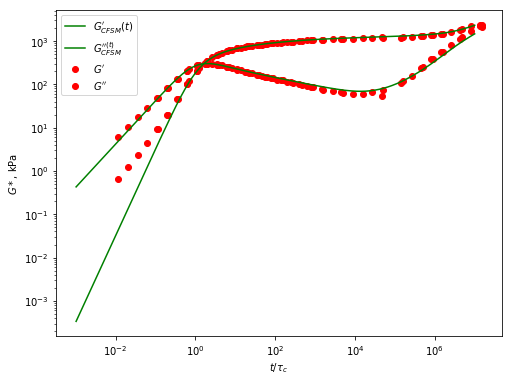

In [7]:
npoints=1000
xrange=10**(-3+(np.array(range(npoints), float) + 1.0)/npoints*10)
CFSM_d=GsCFSM_vec(xrange*tauc, Nc)
R_d=GsR_vec(xrange*tauk*beta**2)
Gp_calc=rho*R*(T + 273.15)/Mw*(0.5*(Nc - 3)*CFSM_d[0]+(NK-beta)/(beta+1)*R_d[0])
Gdp_calc=rho*R*(T + 273.15)/Mw*(0.5*(Nc - 3)*CFSM_d[1]+(NK-beta)/(beta+1)*R_d[1])

fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(111)

# ax1.set_title("Entanglement lifetime distribution")
ax1.set_xlabel(r'$t/\tau_c$')
ax1.set_ylabel(r'$G*$, kPa')

ax1.scatter(t,Gp/1e3, c='r', label=r'$G^\prime$')
ax1.scatter(t,Gdp/1e3, c='r', label=r'$G^{\prime\prime}$')
ax1.plot(xrange,Gp_calc, c='g', label=r'$G_{CFSM}^\prime(t)$')
ax1.plot(xrange,Gdp_calc, c='g', label=r'$G_{CFSM}^{\prime\prime(t)}$')

leg = ax1.legend()
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.show()